Week1 teaches:
1. how to read the reference genome fa file with line starting # as header
2. how to read the sequencing reads fastq file with four lines for each read
3. how to count the frequencies of each base in sequencing reads
4. how to make the alignment of reads from fastq file back to its reference genome fa file

文件：https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/lambda_virus.fa

In [4]:
def readGenome(filename):
    '''
    Reads the reference genome
    '''
    genome=''
    with open(filename,'r') as f:
        for line in f:
            if not line[0] == '>':
                genome += line.rstrip()
    return genome

genome = readGenome('lambda_virus.fa')

genome[:50]                

'GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAA'

#### 1. count the frequencies of each base

In [6]:
def frequencyCount(ge):
    dt = {}
    for i in ge:
        if i not in dt:
            dt[i] = 1
        else:
            dt[i] = dt[i] + 1
    print(dt)

frequencyCount(genome)

{'G': 12820, 'C': 11362, 'A': 12334, 'T': 11986}


In [7]:
import collections
collections.Counter(genome)

Counter({'G': 12820, 'C': 11362, 'A': 12334, 'T': 11986})

https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/SRR835775_1.first1000.fastq

In [8]:
def readFastq(filename):
    sequences = []
    qualities = []
    with open(filename) as fh:
        while True:
            fh.readline()
            seq = fh.readline().rstrip()
            fh.readline()
            qual = fh.readline().rstrip()
            if len(seq) == 0:
                break
            sequences.append(seq)
            qualities.append(qual)
    return sequences, qualities

seq, qua = readFastq('SRR835775_1.first1000.fastq')

In [10]:
seq[:5]

['TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTCACCCTAACCCTAACCCTAACCGTATCCGTCACCCTAACCCTAAC',
 'TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC',
 'TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG',
 'TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAAGGGTTGGGGGTTAGGGGTAGGGGTAGGGTTA',
 'CTAACCCTAACCCTAACCCTAACCCTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACCCTAACCCTAACCCTCACC']

In [11]:
qua[:5]

['???B1ADDD8??BB+C?B+:AA883CEE8?C3@DDD3)?D2;DC?8?=BAD=@C@(.6.6=A?=?@##################################',
 'CCCFFFFFGHHGHJJJJJIJGIIJJJJJJJIJIJJJJJFJJFGIIIIH=CBFCF=CCEG)=>EHB2@@DEC>;;?=;(=?BBD?59?BA###########',
 '@@<DD?DDHHH<CBHII:CFGIGAGHIIG?CCGGE0BDHIIHIGICH8=FHGI=@EHGGGEEHH>);?CC@.;(=;?59,5<A599?CB>ABBCB><88A',
 '@CCFFDDFHHHDFHIJJCGGIJJHIIHJC?DHHIJ0?DGHI9BBFHICGGIGI=CDEGI=?AAEF7@?################################',
 '@<@FDFDDBBFHH@EBGGGEH@FFHE;EHIEGGBHG?)9?8BDGGBGGBCDGI=93=C6==C;CCD(?@>@#############################']

### 2. Draw the score distribution

In [12]:
def phred33ToQ(i):
    return ord(i) - 33

In [13]:
phred33ToQ('#')

2

In [15]:
def createHist(qualities):
    hist = [0] * 50
    for qual in qualities:
        for phred in qual:
            q = phred33ToQ(phred)
            hist[q] += 1
    return hist
h = createHist(qua)
print(h)

[0, 0, 6178, 0, 0, 54, 108, 574, 345, 83, 193, 124, 79, 165, 49, 236, 184, 327, 514, 238, 531, 254, 313, 798, 992, 888, 1396, 1488, 993, 1752, 3387, 4487, 3248, 5476, 8375, 11814, 4243, 7827, 6579, 8179, 9349, 8180, 0, 0, 0, 0, 0, 0, 0, 0]


<BarContainer object of 50 artists>

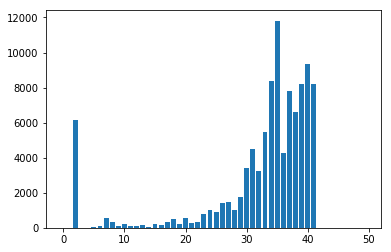

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(range(len(h)), h)

In [27]:
def findGBByPos(reads):
    gc = [0] * 100
    num_reads = len(reads)
    for r in reads:
        for i, b in enumerate(r):
            if b == 'G' or b == 'C':
                gc[i] += 1
    return gc, [r / num_reads for r in gc]
gcContent, total_gc = findGBByPos(seq)

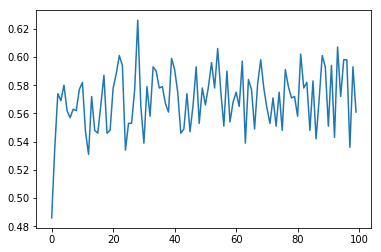

In [32]:
plt.plot(range(len(total_gc)), total_gc)

In [36]:
import collections
count = collections.Counter()
for r in seq:
    count.update(r)
print(count)

Counter({'G': 28742, 'C': 28272, 'T': 21836, 'A': 21132, 'N': 18})


#### if we have a reference genome, we can do alignment. If we don't have a reference genome, we do assembly.

## Matching

### 1. Exact match

#### naive algorithm - A forward (left-right) matching algorithm

In [37]:
pattern = 'word'
text = 'I find a word'
text.find(pattern)

9

In [44]:
p_l = len(pattern)
t_l = len(text)
occurence = []
for i in range(t_l - p_l + 1):
    match = True
    for j in range(p_l):
        # 如果在pattern与text对比过程中，只要发现一个mismatch即可停止对比
        # 将match改设为 False，text对比起始点位向前移动一格
        if pattern[j] != text[i + j]:
            match = False
            break
    # 如果在pattern与text对比过程中，没有mismatch，此时match为True
    if match:
        occurence.append(i)
occurence        

[9]

https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/phix.fa

In [45]:
# read the reference genome
genome = readGenome('phix.fa')

In [53]:
def naive(p, t):
    p_l = len(p)
    t_l = len(t)
    occurence = []
    for i in range(t_l - p_l + 1):
        match = True
        for j in range(p_l):
            # 如果在pattern与text对比过程中，只要发现一个mismatch即可停止对比
            # 将match改设为 False，text对比起始点位向前移动一格
            if p[j] != t[i + j]:
                match = False
                break
        # 如果在pattern与text对比过程中，没有mismatch，此时match为True
        if match:
            occurence.append(i)
    return occurence     

In [54]:
t = 'AGCTTAGATAGC'
p = 'AG'
naive(p, t)

[0, 5, 9]

In [58]:
import random
def generateReads(genome, numReads, readLen):
    '''
    This function generates artificial reads from a reference genome
    '''
    reads = []
    for _ in range(numReads):
        start = random.randint(0, len(genome)-readLen) - 1
        reads.append(genome[start : start+readLen])
    return reads

In [69]:
#Generates artificial reads from reference genome 

artificial_reads = generateReads(genome, 100, 100)

numMatched = 0
for r in artificial_reads:
    matches = naive(r, genome)
    if len(matches) > 0:
        numMatched += 1
print("%d / %d reads matched exactly" % (numMatched, len(reads)))

100 / 100 reads matched exactly


In [60]:
reads[:3]

['TGGCACAATGCTACAATGTGCTCCCCCAACTTGATATTAATAACACTATAGACCACCGCCCCGAAGGGGACGAAAAATGGTTTTTAGAGAACGAGAAGAC',
 'GGGTACGCAATCGCCGCCAGTTAAATAGCTTGCAAAATACGTGGCCTTATGGTTACAGTATGCCCATCGCAGTTCGCTACACGCAGGACGCTTTTTCACG',
 'CGGTAAAGCTGATGGTATTGGCTCTAATTTGTCTAGGAAATAACCGTCAGGATTGACACCCTCCCAATTGTATGTTTTCATGCCTCCAAATCTTGGAGGC']

In [62]:
genome[:300]

'GAGTTTTATCGCTTCCATGACGCAGAAGTTAACACTTTCGGATATTTCTGATGAGTCGAAAAATTATCTTGATAAAGCAGGAATTACTACTGCTTGTTTACGAATTAAATCGAAGTGGACTGCTGGCGGAAAATGAGAAAATTCGACCTATCCTTGCGCAGCTCGAGAAGCTCTTACTTTGCGACCTTTCGCCATCAACTAACGATTCTGTCAAAAACTGACGCGTTGGATGAGGAGAAGTGGCTTAATATGCTTGGCACGTTCGTCAAGGACTGGTTTAGATATGAGTCACATTTTGTT'

In [63]:
r = reads[0]
naive(r, genome) #find a match starting at position 4272 of genome 

[4272]

In [64]:
r = 'XXX'
naive(r, genome) #not find a match

[]

Load the reads for its reference genome. Note: the reference genome is **fa** file while the sequencing reads is **fastq** file.
https://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR037900_1.first1000.fastq

In [70]:
real_reads, _ = readFastq('SRR835775_1.first1000.fastq')

In [74]:
real_reads[:3]

['TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTCACCCTAACCCTAACCCTAACCGTATCCGTCACCCTAACCCTAAC',
 'TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC',
 'TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG']

In [76]:
numMatched = 0
for r in real_reads:
    matches = naive(r, genome)
    if len(matches) > 0:
        numMatched += 1
print("%d / %d reads matched exactly" % (numMatched, len(real_reads)))

0 / 1000 reads matched exactly


In [75]:
numMatched = 0
for r in real_reads:
    matches = naive(r[:30], genome)
    if len(matches) > 0:
        numMatched += 1
print("%d / %d reads matched exactly" % (numMatched, len(real_reads)))

0 / 100 reads matched exactly


Match the reverse complement of the read to the genome, that'll cover the case where the read comes from the other strand of the genome.

In [66]:
def reverseComplement(s):
    complement = {'A':'T', 'C':'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    t = ''
    for base in s:
        t = complement[base] + t
    return t

In [67]:
numMatched = 0
n = 0
for r in phix_reads:
    r = r[:30]
    matches = naive(r, genome)
    matches.extend(naive(reverseComplement(r), genome))
    n += 1
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome' % (numMatched, n))

NameError: name 'phix_reads' is not defined

### Programming Homework

In [10]:
def readReference(fa):
    genome = ''
    with open(fa) as f:
        for line in f.readlines():
            if not line[0] == '>':
                # rstrip remove the '\n' at the end of each line break
                genome = genome + line.rstrip()
    return genome

genome = readReference('lambda_virus.fa')
genome[:200]

'GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACCCTCTGAAAAGAAAGGAAACGACAGGTGCTGAAAGCGAGGCTTTTTGGCCTCTGTCGTTTCCTTTCTCTGTTTTTGTCCGTGGAATGAACAATGGAAGTCA'

In [19]:
def complementbase(seq):
    complement = {'A':'T', 'C':'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    seq_out = ''
    for b in seq:
        seq_out = complement[b] + seq_out 
    return seq_out

def naive(p, t):
    index = []
    for i in range(len(t) - len(p) + 1):
        match = True
        for j in range(len(p)):
            if not t[i + j] == p[j]:
                match = False
                break
        if match is True:
            index.append(i)
    return index

len(naive('AGGT', genome) + naive(complementbase('AGGT'), genome))

306

In [20]:
len(naive('TTAA', genome))

195

In [21]:
naive('ACTAAGT', genome)[0]

27733

In [23]:
naive('ACTAAGT', genome)

[27733, 45382]

In [22]:
naive(complementbase('ACTAAGT'), genome)[0]

26028

In [24]:
naive('AGTCGA', genome)[0]

18005

In [25]:
naive(complementbase('AGTCGA'), genome)[0]

450

In [28]:
def naive_2mm(p, t):
    index = []
    for i in range(len(t) - len(p) + 1):
        match = True
        counter = 0
        for j in range(len(p)):
            if not t[i + j] == p[j]:
                counter += 1
            if counter > 2:
                match = False
                break
        if match is True:
            index.append(i)
    return index

len(naive_2mm('TTCAAGCC', genome))

191

In [30]:
naive_2mm('AGGAGGTT', genome)[0]

49

In [38]:
def readGenome(fastq):
    readseq = []
    readscore = []
    with open('ERR037900_1.first1000.fastq') as f:
        while True:
            f.readline()
            seq = f.readline().rstrip()
            readseq.append(seq)
            f.readline()
            score = f.readline().rstrip()
            readscore.append(score)
            if len(seq) == 0:
                break
    return readseq, readscore

seq, score = readGenome('ERR037900_1.first1000.fastq')

In [41]:
len(score)

1001

In [40]:
len(score[0])

100

In [48]:
def phred33ToQ(i):
    return ord(i) - 33

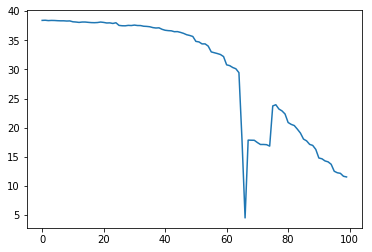

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

def averageScore(score_list):
    len_a = len(score_list)
    len_b = len(score_list[0])
    score_output = [0] * len_b
    for i in score_list:
        for index, value in enumerate(i):
            score_output[index] = score_output[index] + phred33ToQ(value)
    return [s / len_a for s in score_output]

plt.plot(averageScore(score))

In [58]:
for i, v in enumerate(averageScore(score)):
    print(i, v)

0 38.396603396603396
1 38.421578421578424
2 38.36163836163836
3 38.38961038961039
4 38.37862137862138
5 38.34365634365634
6 38.323676323676324
7 38.32567432567433
8 38.28671328671329
9 38.30469530469531
10 38.15584415584416
11 38.115884115884114
12 38.05094905094905
13 38.11388611388612
14 38.11488511488511
15 38.06093906093906
16 38.01698301698302
17 38.002997002997006
18 38.02897102897103
19 38.11188811188811
20 38.04895104895105
21 37.95104895104895
22 37.97102897102897
23 37.871128871128874
24 37.99000999000999
25 37.53846153846154
26 37.476523476523475
27 37.46553446553447
28 37.54045954045954
29 37.514485514485514
30 37.591408591408594
31 37.51748251748252
32 37.51048951048951
33 37.395604395604394
34 37.36463536463536
35 37.3056943056943
36 37.16083916083916
37 37.08891108891109
38 37.120879120879124
39 36.86713286713287
40 36.705294705294705
41 36.64035964035964
42 36.60839160839161
43 36.45654345654346
44 36.472527472527474
45 36.33866133866134
46 36.16883116883117
47 35.93806